I want to apologize for the somewhat chaotic transition this notebook has gone through. I had an issue where tensorflow decided to no longer recognize my GPU after an update. Despite significant effort I wasn't able to get back to GPU operationability. I switched tactics to using Google Colab, but found out that they limit the time a notebook can run for. Meaning I wasn't able to use architectures of significant complexity, nor train for more than 25 epochs. But we must make do with the tools we have at the time.

Thank you for your patience reading this notebook.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from numpy.random import choice
import glob
#import imageio
import xml
import xml.etree.ElementTree as ET
import time
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import NumpyArrayIterator, ImageDataGenerator
import IPython
from IPython import display
from tqdm import tqdm

import pickle
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(tf.config.list_physical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.8.0


In [4]:
!pwd
!ls
!ls drive/MyDrive/generative-dog-images/all-dogs/

/content
drive  sample_data
all-dogs


## Image Pathing
Since the images are in a seperate folder from the image meta data (including but not limited to breed, stance, and a bounding box of just the dog) it is important that we keep our paths in an organized fashion. We will be storing the root of the image and annotation file in variables, and then creating a list of all the files contained there in. It should be noted that the annotation file structure has a seperate file for each of the breeds, so we will need to have a way of indicating not just the file path, but seperating out the breed information to access the correct subdirectory in annotations.

In [5]:
root_img = "drive/MyDrive/generative-dog-images/all-dogs/all-dogs"
root_anot = "drive/MyDrive/generative-dog-images/Annotation/Annotation/"
#root_img = ".\\generative-dog-images\\all-dogs\\all-dogs\\"
#root_annot = ".\\generative-dog-images\\Annotation\\Annotation\\"

In [6]:
#os.listdir("drive/MyDrive/generative-dog-images/all-dogs/all-dogs")
#image_paths = os.listdir(root_img)
#print(len(image_paths))
#for image in image_paths:
#    print(image)

In [7]:
#annot_breed_paths = os.listdir(root_anot)
#for annot in annot_breed_paths:
#    print(annot)

### Breed Information
Since the file system is making us iterate through each of the breed subdirectories we will store those directory names in a variable called breeds. We can then access all the images in each of those subdirectoreies by looping through and using the glob library.

The glob library is incredibly useful, it lists all of the files and directories matching a certain pattern, in path form, that it is fed. For instance, in the first line below we use glob on the annotation root path, this yields all the names of the breed subdirectories, and from there we can loop through the breed subdirectories and get the full file path of all of the annotation files.

In [8]:
#breeds = glob.glob('drive/MyDrive/generative-dog-images/Annotation/Annotation/*')
#annotation_path = []
#for breed in breeds:
##    annotation_path += glob.glob(breed+"/*")
#breed_dict = {}
#for annotation in annotation_path:
#    breed = annotation.split("/")[-2]
#    index = breed.split("-")[0]
#    if index not in breed_dict:
#        breed_dict[index] = breed
#for key in breed_dict:
#    print(f"{key} : {breed_dict[key]}")

## Bounding Box
Probably the most important information found in the annotation data is the bounding box coordinates for every picture. This means that the coordinates given create a box in the picture around where the dog appears. This is incredibly useful for our project because it means that we can train our GAN on pictures where the dog is the primary focus and we don't have to worry about photos raning quite as much in content.

In [9]:
def bounding_box(image):
    part1 = str(breed_dict[image.split("_")[0]])
    part2 = str(image.split(".")[0])
    xml=root_anot+part1+"/"+part2
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        name = o.find('name').text
        bndbox = o.find('bndbox') # reading bouand box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax,name)

### Bounding Box Results
With the bounding box in use we can see in the photos below that the cropped images only contain the dogs in each photo and have cropped out all of the extra photo material. The 15 examples below all appear to be chiuauas.

In [10]:
#plt.figure(figsize=(50,25))
#for i,image in enumerate(image_paths):
#    xmin,ymin,xmax,ymax,name=bounding_box(image)
#    bbox = (xmin, ymin, xmax, ymax)
#    im=Image.open(os.path.join(root_img,image))
#    im=im.crop(bbox)
#    
#    plt.subplot(5,3,i+1)
#    plt.axis("off")
#    plt.imshow(im)    
#    if(i==14):
#        break

In [11]:
def crop_image(path):
    xmin, ymin, xmax, ymax, name = bounding_box(path)
    full_path = os.path.join(root_img, path)
    PIL_img = PIL.Image.open(full_path)
    resulting_crop = PIL_img.crop((xmin, ymin, xmax, ymax))
    resized_img = resulting_crop.resize((64, 64), PIL.Image.ANTIALIAS)
    return resized_img, name

In [12]:
#cropped_images = []
#image_labels = []
#for  image in tqdm(image_paths):
#    cropped = crop_image(image)
#    name = cropped[1]
#    img = cropped[0]
##    cropped_images.append(img)
#    image_labels.append(name)
fh = open("drive/MyDrive/generative-dog-images/cropped_images", "rb")
cropped_images = pickle.load(fh)
fh.close()
fh1 = open("drive/MyDrive/generative-dog-images/image_labels", "rb")
image_labels = pickle.load(fh1)
fh1.close()

In [13]:
len(cropped_images)

20579

In [14]:
cropped_images[14000]

array([[[111, 142,  77],
        [ 84, 112,  62],
        [ 60, 102,  26],
        ...,
        [ 18,  33,  30],
        [ 22,  46,  40],
        [ 20,  51,  43]],

       [[151, 185, 114],
        [135, 169, 106],
        [ 82, 120,  52],
        ...,
        [ 19,  35,  30],
        [ 20,  41,  34],
        [ 24,  51,  42]],

       [[126, 160,  96],
        [126, 167,  93],
        [111, 146,  78],
        ...,
        [ 19,  36,  28],
        [ 15,  35,  26],
        [ 19,  41,  31]],

       ...,

       [[229, 226, 220],
        [206, 203, 193],
        [207, 202, 190],
        ...,
        [ 88,  91,  82],
        [134, 133, 122],
        [102,  98,  86]],

       [[220, 213, 204],
        [212, 210, 201],
        [233, 230, 219],
        ...,
        [ 96,  97,  84],
        [221, 214, 203],
        [210, 204, 195]],

       [[189, 179, 166],
        [206, 205, 198],
        [221, 218, 210],
        ...,
        [133, 132, 115],
        [195, 195, 167],
        [166, 177, 144]]

While having an array of cute dogs is an attractive idea for getting through this project, it is unfortunately not what we need at this point. For the GAN we need to convert all of these images to numeric arrays.

In [15]:
for i in range(len(cropped_images)):
    cropped_images[i] = np.asarray(cropped_images[i])
cropped_images[14000]

array([[[111, 142,  77],
        [ 84, 112,  62],
        [ 60, 102,  26],
        ...,
        [ 18,  33,  30],
        [ 22,  46,  40],
        [ 20,  51,  43]],

       [[151, 185, 114],
        [135, 169, 106],
        [ 82, 120,  52],
        ...,
        [ 19,  35,  30],
        [ 20,  41,  34],
        [ 24,  51,  42]],

       [[126, 160,  96],
        [126, 167,  93],
        [111, 146,  78],
        ...,
        [ 19,  36,  28],
        [ 15,  35,  26],
        [ 19,  41,  31]],

       ...,

       [[229, 226, 220],
        [206, 203, 193],
        [207, 202, 190],
        ...,
        [ 88,  91,  82],
        [134, 133, 122],
        [102,  98,  86]],

       [[220, 213, 204],
        [212, 210, 201],
        [233, 230, 219],
        ...,
        [ 96,  97,  84],
        [221, 214, 203],
        [210, 204, 195]],

       [[189, 179, 166],
        [206, 205, 198],
        [221, 218, 210],
        ...,
        [133, 132, 115],
        [195, 195, 167],
        [166, 177, 144]]

Not quite as cute, but more useful for ultimate goal of producing more pictures of dogs.

In [16]:
Total_images = len(cropped_images)
print(Total_images)

20579


## Preparing a method for loading the data into our GAN
We are going to use two elements of the keras framework, the first is an ImageDataGenerator which will be responsible for the manipulation of images that are being fed into our system. The ImageDataGenerator can accomplish tasks such as flipping a picture horizontally, rotating a picture, changing the color values, and even rescaling a picture. We will only be using the horizontal and vertical flip functions.

The second element is an iterator, this will let us loop through the images in a controlled fashion, holding the labels and images together as well as shuffling the data.

One additional step we are going to take is normalizing the values of all the pixels around 0, so since the maximum pixel value is 255 we will subtract half of that (127.5) and then divide by the half mark as well. This means that our data will all fall within the range [-1,1].

In [17]:
Img_Generator = ImageDataGenerator(vertical_flip = True, horizontal_flip = True)

#Normalize all of the training images
Norm_images = (np.array(cropped_images)-127.5)/127.5
Norm_images = tf.cast(Norm_images, 'float32')
labels = np.asarray(image_labels)
#training_data = NumpyArrayIterator(Norm_images,
#                                   labels,
#                                   batch_size = 128,
#                                   image_data_generator = Img_Generator,
#                                   shuffle = True
#                                  )
training_data = tf.data.Dataset.from_tensor_slices(Norm_images).shuffle(20000).batch(16)

## Overall Design
Our GAN will consist of a generator model and a discriminator model. These two models will be designed seperately and trained together to ensure a lockstep of progress. Our goal will be to maximize the discriminator loss function while minimizing the generator model's loss.

### Discriminator
Our discriminator will be composed taking a (64, 3, 3) sized "picture" and deciding whether or not it resembles the dogs in the training set. Training the discriminator will take a soft touch, if we overfit the training data, our generator will be unnecessarily confined to trying to recreate the exact pictures of the training set, while if we are overly generous with the dicriminator the generator will never approach the level of capability we desire.

In [18]:
def discriminator_model():
    mod = tf.keras.Sequential()
    
    #first convolution 64 filters
    mod.add(layers.Conv2D(64, (5, 5), strides = 2, padding = 'same', input_shape = [64, 64, 3]))
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))
    print(mod.output_shape)
    
    #second convolution 64 filters
#    mod.add(layers.Conv2D(64, (5,3), strides = 1, padding = 'same'))
#    mod.add(layers.LeakyReLU())
#    mod.add(layers.Dropout(0.33))
#    print(mod.output_shape)

    
    #third convolution 64 filters
#    mod.add(layers.Conv2D(32, (3,3), strides = 2, padding = 'valid'))
#    mod.add(layers.LeakyReLU())
#    mod.add(layers.Dropout(0.33))
#    print(mod.output_shape)

    
    mod.add(layers.Conv2D(16, (5,5), strides = 2, padding = 'same'))
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))  
    print(mod.output_shape)

    
    #Flatten
    mod.add(layers.Flatten())
#    mod.add(layers.Dense(256, activation = 'relu'))
    print(mod.output_shape)

    mod.add(layers.Dropout(0.5))
    mod.add(layers.Dense(1, activation = 'sigmoid'))
    print(mod.output_shape)

    
    return mod

In [19]:
discriminator = discriminator_model()
discriminator.summary()

(None, 32, 32, 64)
(None, 16, 16, 16)
(None, 4096)
(None, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        25616     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 16)        0         
                                                             

### Generator
The generator is slightly more complicated, we need to transform an array of 100 values into a (64, 64, 3) image. 
The majority of the heavy lifting on this will be done by the 2D Transpose of convolutional layer (essentially turning flat objects into expanded square objects).


In [20]:
def generator_model():
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.25)
    mod = tf.keras.Sequential()
    mod.add(layers.Dense(4*4*1024, input_shape = (100,), use_bias = False))
    mod.add(layers.BatchNormalization())
    mod.add(layers.LeakyReLU())
    mod.add(layers.Reshape((4, 4, 1024)))
    
    assert mod.output_shape == (None, 4, 4, 1024)
    
    #First of 4 Conv2D Transposes
    mod.add(layers.Conv2DTranspose(256, (3,3), 
                                   strides = 2, 
                                   padding = 'same', 
                                   use_bias = False,
                                   kernel_initializer = init
                                  ))
    print(mod.output_shape)
    #assert mod.output_shape == (None, 8, 8, 512)
    mod.add(layers.BatchNormalization())
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))
    
    mod.add(layers.Conv2DTranspose(128, (3,3),
                                   strides = 2,
                                   padding = 'same',
                                   use_bias = False,
                                   kernel_initializer = init
                                  ))
    print(mod.output_shape)
    mod.add(layers.BatchNormalization())
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))
    
    mod.add(layers.Conv2DTranspose(64, (3,3), 
                                   strides = 2,
                                   padding = 'same',
                                   use_bias = False,
                                   kernel_initializer = init
                                  ))
    print(mod.output_shape)
    mod.add(layers.BatchNormalization())
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))
    
    mod.add(layers.Conv2DTranspose(32, (3,3),
                                   strides = 2,
                                   padding = 'same',
                                   use_bias = False,
                                   kernel_initializer = init
                                  ))
    mod.add(layers.BatchNormalization())
    mod.add(layers.LeakyReLU())
    mod.add(layers.Dropout(0.33))
    print(mod.output_shape)
    
#    mod.add(layers.Dense(9, use_bias = False, activation = 'softmax'))
#    print(mod.output_shape)
#    mod.add(layers.Dropout(0.33))
    mod.add(layers.Dense(3, use_bias = False, activation = 'tanh'))
#    print(mod.output_shape)

    
    return mod

In [21]:
generator = generator_model()
generator.summary()

(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 64, 64, 32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        2359296   
 nspose)                                                         
                                            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[ 0.99990165  0.9938321  -0.9999953 ]
   [-0.99841845  0.94778484 -0.999793  ]
   [ 0.96958625  0.99325085 -1.        ]
   ...
   [ 1.         -0.9648947  -1.        ]
   [ 0.98603046 -1.         -1.        ]
   [ 0.9991147  -0.91264904  0.99999565]]

  [[ 0.98927844 -0.9960256   0.9999333 ]
   [ 0.9983775  -0.8806193  -0.99989384]
   [-0.7158539   0.20750637  0.98280823]
   ...
   [ 1.         -1.         -1.        ]
   [-0.9980944  -1.         -1.        ]
   [-0.05569883  1.          0.9990597 ]]

  [[-0.99998075 -1.         -0.9718849 ]
   [-1.          0.99997836 -1.        ]
   [ 0.9546169   0.9999214   0.7326248 ]
   ...
   [ 1.         -1.         -0.999582  ]
   [ 1.         -1.         -1.        ]
   [ 1.          1.         -1.        ]]

  ...

  [[-0.9999966  -1.          1.        ]
   [-0.4579983   1.         -1.        ]
   [ 0.99991095 -1.         -1.        ]
   ...
   [ 1.          1.         -1.        ]
   [ 1.          1.         -1.        ]
   [ 

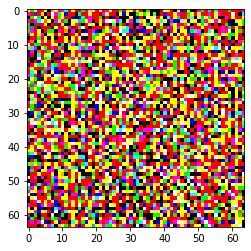

In [22]:
# Example Generator with no training
intake = tf.random.normal([1, 100])
generated_image = generator(intake, training = False)
print(generated_image)
rng_image = (generated_image[0,:,:,:].numpy()* 127.5 + 127.5).astype(int)
print(rng_image)
plt.imshow(generated_image[0,:,:,:])

### Loss Functions
For me the most difficult portion of this project has been wrapping my mind around the implementation of the custom loss functions.
I relied heavily on some of the tricks presented in this notebook: https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow and it took quite a few tries to get the losses right.

In [23]:
# Supporting functions 
def true_smoothing(true_labels):
    return true_labels - 0.3 + (np.random.random(true_labels.shape) * 0.3)

def false_smoothing(false_labels):
    return false_labels + 0.3 * np.random.random(false_labels.shape)
    
loss_fx = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [24]:
# generator loss
def generator_loss(generator_output):
    smoothed_generator_output = true_smoothing(tf.ones_like(generator_output))
    return loss_fx(smoothed_generator_output, generator_output)

def discriminator_loss(true_labels, generator_outputs):
    smoothed_true_labels = true_smoothing(tf.ones_like(true_labels))
    smoothed_generator_outputs = false_smoothing(tf.zeros_like(generator_outputs))
    true_loss = loss_fx(smoothed_true_labels, true_labels)
    generator_loss = loss_fx(smoothed_generator_outputs, generator_outputs)
    return true_loss + generator_loss

### Optimizers
The article on "GAN Hacks" lists adam as the best practice optimizer for both models with a learning rate of 0.002 and a beta of 0.5

In [25]:
generator_opt = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.5)
discriminator_opt = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    beta_1=0.5)

### Training
The training is going to consist of repatedly calling the iterate_training fucntion (written below). The iterate_training function will create the noise array to feed to the generator, then use GradientTape() to create the gradients to pass to the optimizers to update the systems.
The iteration of the training steps is handled by the train() function.

I relied heavily on the GradientTape documentation: https://www.tensorflow.org/api_docs/python/tf/GradientTape, as well as the source posted in class: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [26]:
def iterate_training(real_images, generator_loss_history, discriminator_loss_history):
    #working with batches of 64
    noise_array = tf.random.normal([16, 100])
    
    #set up both of our gradient tapes for discriminator and generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        #generate_images
        gen_img = generator(noise_array, training = True)
        
        #Pass images to discriminator
        real_discriminator_output = discriminator(real_images, training = True)
        generated_discriminator_output = discriminator(gen_img, training = True)
        
        #Calculate Losses
        generator_loss_value = generator_loss(generated_discriminator_output)
        discriminator_loss_value = discriminator_loss(real_discriminator_output, generated_discriminator_output)
    
    #Calculate gradients based on tape observations
    generator_tape_results = gen_tape.gradient(generator_loss_value, generator.trainable_variables)
    discriminator_tape_results = disc_tape.gradient(discriminator_loss_value, discriminator.trainable_variables)
    
    #Update optimizers
    generator_zip = zip(generator_tape_results, generator.trainable_variables)
    discriminator_zip = zip(discriminator_tape_results, discriminator.trainable_variables)
    generator_opt.apply_gradients(generator_zip)
    discriminator_opt.apply_gradients(discriminator_zip)

    return generator_loss_value, discriminator_loss_value

In [27]:
# CHANGE BELOW

In [28]:
import time
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)    
    fig = plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1.)/2.)
        plt.axis('off')
    plt.show()

In [29]:
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        tot_gen_loss = 0.0
        tot_disc_loss = 0.0
        for i, image_batch in enumerate(dataset):
            if i % 50 == 0:
              print(f"Batch {i}/{len(dataset)}")
            gen_loss, disc_loss = iterate_training(image_batch, G_loss, D_loss)
            tot_gen_loss += gen_loss
            tot_disc_loss += disc_loss
        G_loss.append(tot_gen_loss/i)
        D_loss.append(tot_disc_loss/i)
        if (epoch % 5 == 0):
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec')
        
            
    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator,
                           epochs,
                           seed)

    plot_loss(G_loss, D_loss, epoch)


def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch+1))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287


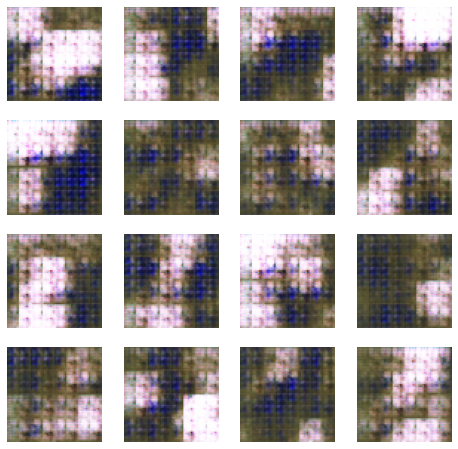

Time for epoch 1 is 169.83055472373962 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 2 is 157.52436876296997 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 3 is 148.912171125412 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287


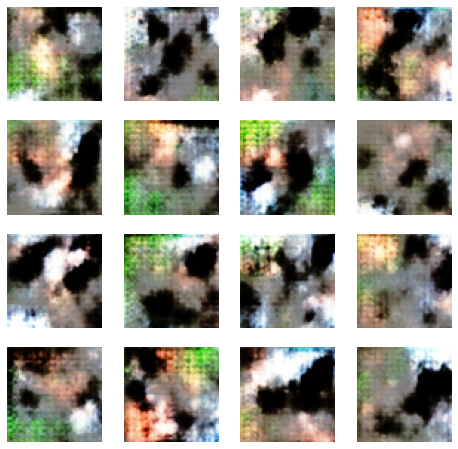

Time for epoch 6 is 156.67607975006104 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 7 is 154.60820817947388 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 8 is 156.07390308380127 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/128

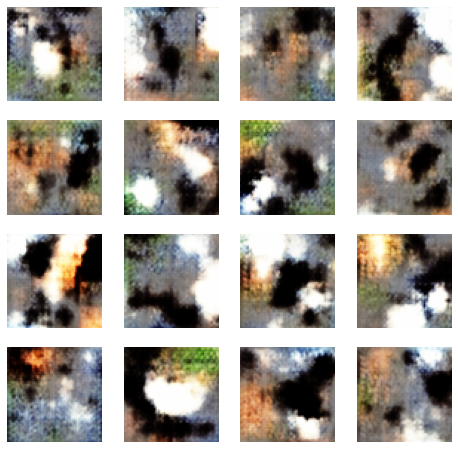

Time for epoch 11 is 160.826313495636 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 12 is 157.31880903244019 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 13 is 157.15485095977783 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/12

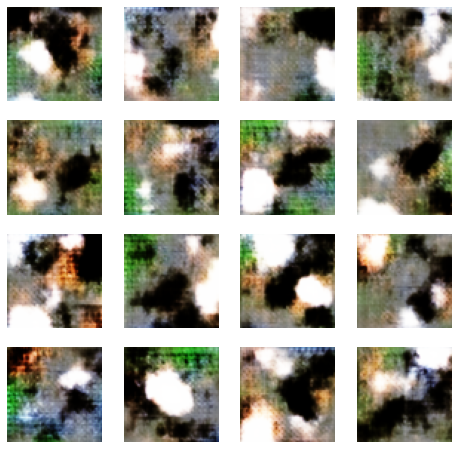

Time for epoch 16 is 155.3854432106018 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 17 is 156.28226399421692 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 18 is 155.29347562789917 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1

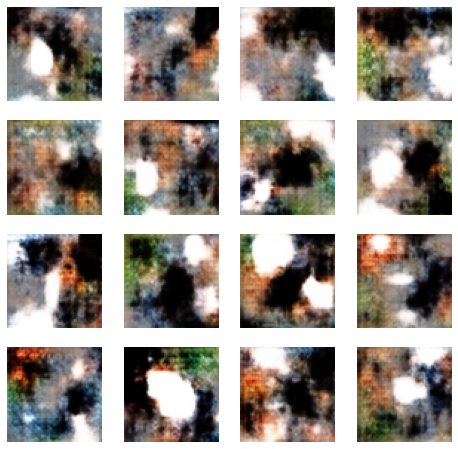

Time for epoch 21 is 151.30034470558167 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 22 is 152.80499958992004 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/1287
Batch 300/1287
Batch 350/1287
Batch 400/1287
Batch 450/1287
Batch 500/1287
Batch 550/1287
Batch 600/1287
Batch 650/1287
Batch 700/1287
Batch 750/1287
Batch 800/1287
Batch 850/1287
Batch 900/1287
Batch 950/1287
Batch 1000/1287
Batch 1050/1287
Batch 1100/1287
Batch 1150/1287
Batch 1200/1287
Batch 1250/1287
Time for epoch 23 is 154.79578590393066 sec
Batch 0/1287
Batch 50/1287
Batch 100/1287
Batch 150/1287
Batch 200/1287
Batch 250/

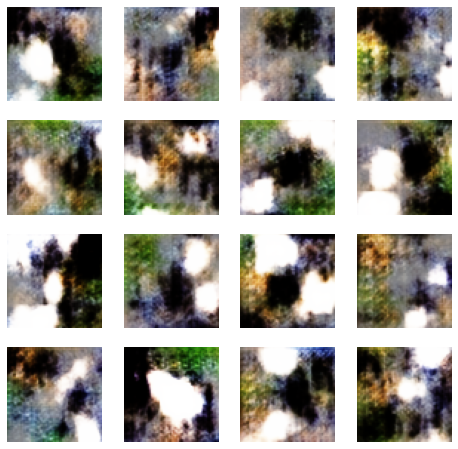

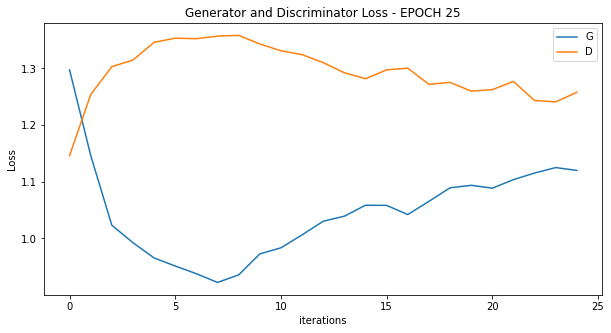

In [30]:
seed = tf.random.normal([16, 100])
train(training_data, 25)

## Analysis:
While we see a promising dip in the Generator loss coupled with a gain the discriminator, the forward progress is shortlived with a back slide in the wrong direction of losses towards the 25th epoch mark. I hypothesize that as time went on we would see a sine wave pattern to this behavior with a more concrete plateau at a much later epoch. However with the GPU issues, we wont know until I take the time to resolve the GPU issues or translate to pytorch.

## Alternate Architectures:
I initially tried to produce a much more complex structure with 6 convolutional layers in the generator and additional layers both dense and convolutional in the discriminator. However due to the GPU issues I was facing and the somewhat unknown time constraints imposed by Google Colab I was never able to train any of those architectures to frutition (nor frankly am I entirely satisified with this architecture given the number of epochs). The early phases of my first larger architecture seemed promising showing similar characteristics to the early phase of the current architecture, but by the 20th epoch my larger architecture had displayed a shift in color choices focusing on Purples and Blues instead of more traditional dog colors. My conclusion is that the discriminator was not able to keep up with the generator and was being too accepting of the generated images.

## Conclusion:
Despite some serious issues with tensorflow (2.3+) and an issue with identifying gpu's on windows 10 machines we have arrived at a working GAN. Unfortunately the amount of training we are able to complete with the model is limited by Google Colab's resource rationing. In a perfect world we would allow the model to run 100+ epochs, unfortonuately we have been limited to 25 epochs. We can still see though from the output of the last epoch that the model is indeed approaching a more dog like resemblence, in some of the photos you can see what could be identified as the eye, nose combo for a dog, as well as general coloring and shapes that are dog like.

Another issue with this project is that we don't have access to submission for the kaggle competition. Thus we can't judge how well our GAN is performing based on their evaluation metric. So we are stuck with a sort of psuedoscience evaltion of loss metrics as well as visual inspection of the generators capabilities. In a perfect world the generators pictures could fool the human eye, for these pictures that is certainly not the case. But the last batch is better than the first, and more epochs may make that better.

If I were to repeat this project I would like to see the effects of 100+ epochs on the ability of the GAN to produce more believable representations of dogs. However given the constraints of Google Colab I was limited in my epoch count. I predict that the the graph of loss functions would take on a somewhat sinusoidal pattern as the discriminator and generator worked against one another to optimize their loss functions.

### References:
1. https://www.kaggle.com/code/whizzkid/crop-images-using-bounding-box/notebook
2. https://www.kaggle.com/code/jpdurham/tensorflow-dcgan
3. https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow
4. https://keras.io/api/layers/convolution_layers/convolution2d_transpose/
5. https://www.youtube.com/watch?v=96_oGE8WyPg
6. https://www.tensorflow.org/api_docs/python/tf/GradientTape
7. https://developers.google.com/machine-learning/gan/loss
8. https://keras.io/examples/generative/dcgan_overriding_train_step/
9. https://stats.stackexchange.com/questions/242907/why-use-binary-cross-entropy-for-generator-in-adversarial-networks
10. https://blockgeni.com/gan-hacks-to-train-stable-gan/